# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [1]:
# Installing the libraries with the specified version.
# uncomment and run the following line if Google Colab is being used
!pip install tensorflow==2.15.0 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.25.2 pandas==1.5.3 opencv-python==4.8.0.76 -q --user

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [2]:
import os
import gc
import re
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import scipy as sp
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import matplotlib.cm as cm

# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import SVG
from keras.utils import plot_model
from tensorflow.keras.applications import ResNet50
import tensorflow.keras.layers as L
from keras.utils import model_to_dot
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight


# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images
from tensorflow.keras import backend
from keras.callbacks import ReduceLROnPlateau

tqdm.pandas()
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [3]:
# loading data
labels = pd.read_csv('/content/Labels.csv')

In [4]:
# loading images data
images = np.load('/content/images.npy')

## Data Overview

### Understand the shape of the dataset

In [5]:
# check the shape of images and labels
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


There are 4750 images that are 128 x 128 with 3 channels each.

### Plot images using OpenCV and Matplotlib

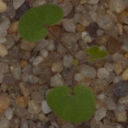

In [6]:
# look at a sample of the images with cv2
cv2_imshow(images[6])

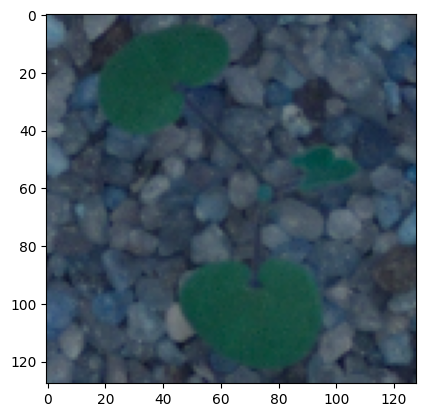

In [7]:
# look at sample image with matplotlib
plt.imshow(images[6])

I can see that the images are in BGR format so I will need to convert them to RGB.

In [8]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Inspect labels

In [9]:
# check the shape of labels
print(labels.shape)
print(images.shape)

(4750, 1)
(4750, 128, 128, 3)


In [10]:
labels.head()

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


In [11]:
# statistical summary
labels.describe().T

,count,unique,top,freq
Label,4750,12,Loose Silky-bent,654


* There are 12 different catagories of plants.

In [12]:
# check for missing data
labels.isnull().sum()

Label    0
dtype: int64

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

### Images EDA

In [13]:
def plot_images(images,labels):
  num_classes=12                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

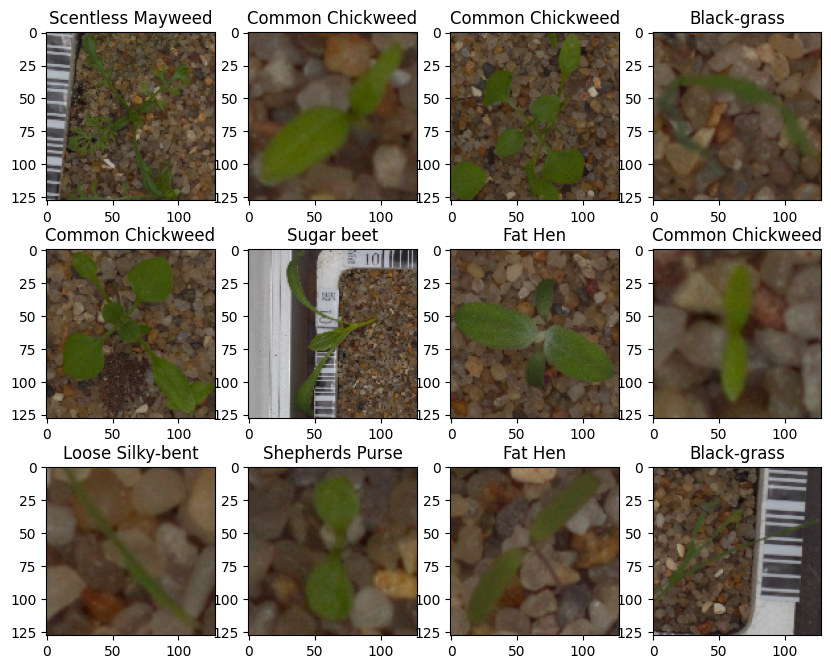

In [14]:
plot_images(images,labels)

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 [Text(0.0, 0, '0'),
  Text(100.0, 0, '100'),
  Text(200.0, 0, '200'),
  Text(300.0, 0, '300'),
  Text(400.0, 0, '400'),
  Text(500.0, 0, '500'),
  Text(600.0, 0, '600'),
  Text(700.0, 0, '700')])

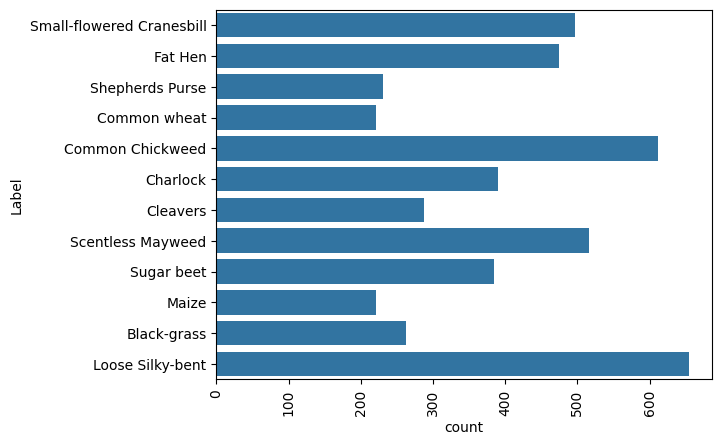

In [15]:
# check for data imbalances
sns.countplot(labels['Label'])
plt.xticks(rotation='vertical')

* The dataset is very unbalanced.

## Data Pre-Processing

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; so I will decrease the size to 64 x 64.

In [16]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

# Convert the list back to a numpy array
images_decreased = np.array(images_decreased)

print(images_decreased.shape)

(4750, 64, 64, 3)


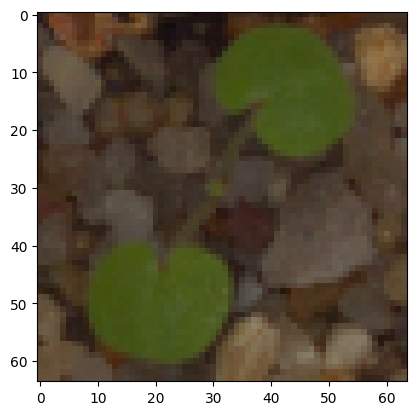

In [17]:
# check a sample image to make sure the size is correct
plt.imshow(images_decreased[5])

* images are now 64 x 64

### Apply SMOTE to rebalance the data and encode target variable

In [18]:
# Flatten the images
images_flatten = images_decreased.reshape(images_decreased.shape[0], -1)

In [19]:
from sklearn.preprocessing import LabelEncoder

# Convert string labels to integer labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [20]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(images_flatten, labels_encoded)

In [21]:
# Reshape resampled features back to original (resized) image shape
X_resampled_reshaped = X_resampled.reshape(X_resampled.shape[0], height, width, 3)

## Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [22]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Convert resampled labels to categorical
num_classes = len(label_encoder.classes_)
y_resampled_categorical = to_categorical(y_resampled, num_classes=num_classes)

# Split data into temporary set and test set
X_temp, X_test, y_temp, y_test = train_test_split(X_resampled_reshaped, y_resampled_categorical, test_size=0.2, random_state=42, stratify=y_resampled_categorical)

# Split temporary set into training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

# Print shapes to verify
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (5022, 64, 64, 3) (5022, 12)
Validation set shape: (1256, 64, 64, 3) (1256, 12)
Test set shape: (1570, 64, 64, 3) (1570, 12)


### Data Normalization

I will normalize the images while rebalancing the classes with Imagedatagenerator.

In [23]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0


### Data Augmentation

In [47]:
# Define the image data generators
train_datagen = ImageDataGenerator(

    rotation_range=20,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #shear_range=0.1,
    zoom_range=0.1,
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode='nearest'
)

# test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

## Model Building

First clear the backend and set the seed.

In [48]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [49]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

Build the feature extraction layers with convolutional and pooling layers.
Add fully connected classification layers for prediction.

In [51]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))
#model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(16, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(8, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(Dropout(0.5))
#model.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
#opt = SGD(learning_rate=0.001, momentum=.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False)
# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    verbose=1,
    mode='auto',
    min_lr=0.00001
)

# Generating the summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 16)        9232      
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 16)       

Fit the model on train data

In [52]:
# Epochs
epochs = 30
# Batch size
batch_size = 32

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_resampled), y=y_resampled)
class_weights_dict = dict(enumerate(class_weights))

history = model.fit(train_datagen.flow(X_train_normalized,y_train,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val),
                    class_weight=class_weights_dict,
                    #callbacks=[reduce_lr],
                    verbose=1)

Epoch 1/30
156/156 [==============================] - 9s 37ms/step - loss: 2.4663 - accuracy: 0.1036 - val_loss: 2.4287 - val_accuracy: 0.1186
Epoch 2/30
156/156 [==============================] - 5s 34ms/step - loss: 2.3722 - accuracy: 0.1531 - val_loss: 2.0941 - val_accuracy: 0.1975
Epoch 3/30
156/156 [==============================] - 5s 34ms/step - loss: 2.0689 - accuracy: 0.2210 - val_loss: 1.9561 - val_accuracy: 0.2651
Epoch 4/30
156/156 [==============================] - 5s 33ms/step - loss: 1.8945 - accuracy: 0.3002 - val_loss: 1.8618 - val_accuracy: 0.3495
Epoch 5/30
156/156 [==============================] - 5s 34ms/step - loss: 1.7934 - accuracy: 0.3427 - val_loss: 1.6806 - val_accuracy: 0.3838
Epoch 6/30
156/156 [==============================] - 5s 35ms/step - loss: 1.7681 - accuracy: 0.3525 - val_loss: 1.6992 - val_accuracy: 0.3742
Epoch 7/30
156/156 [==============================] - 5s 34ms/step - loss: 1.6834 - accuracy: 0.3892 - val_loss: 1.6303 - val_accuracy: 0.3989

### Model Evaluation

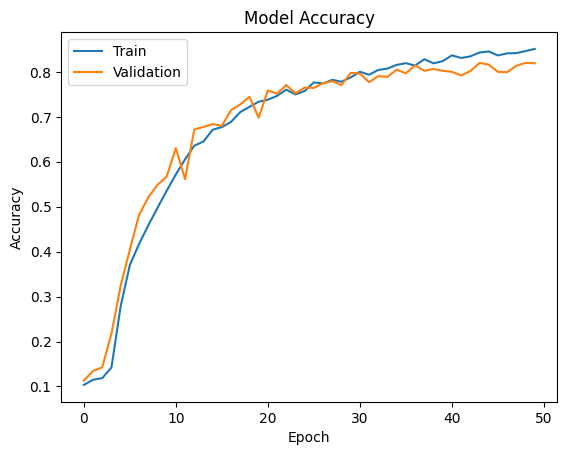

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Observations:
* Initially I was getting some overfitting and very poor accuracy. I moved on to my second model then came back and worked on this model a lot more.
* After a lot of itterations, adjustments, bugs, and heartach I got this model to perform pretty well.
* Val accuracy at 81.46%, loss 0.5682

### **Evaluating the model on test data**

In [ ]:
accuracy = model.evaluate(X_test_normalized, y_test, verbose=2)

50/50 - 0s - loss: 0.5682 - accuracy: 0.8146 - 310ms/epoch - 6ms/step


### **Generating the predictions using test data**

In [ ]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

50/50 [==============================] - 0s 5ms/step


In [ ]:
y_pred

array([[8.9371013e-13, 9.9682164e-01, 7.7543053e-04, ..., 2.5675459e-05,
        2.3338799e-03, 1.4035513e-07],
       [1.9316984e-08, 9.8159731e-08, 1.1946631e-06, ..., 2.5952862e-05,
        3.2964027e-01, 1.9122248e-05],
       [5.0734980e-07, 8.7714382e-04, 9.5725012e-01, ..., 7.2084542e-05,
        4.0939805e-05, 5.1491792e-05],
       ...,
       [1.9335407e-11, 1.6509248e-04, 9.5782584e-01, ..., 2.8218066e-05,
        8.1964144e-03, 5.9126731e-04],
       [3.4462269e-06, 1.3447633e-03, 2.4323968e-02, ..., 6.1215676e-04,
        3.2554912e-05, 9.5225777e-03],
       [5.3462430e-09, 2.0439371e-05, 5.4932135e-04, ..., 3.5803553e-03,
        8.5936299e-06, 6.3410040e-04]], dtype=float32)

### **Plotting the Confusion Matrix**

*   The Confusion matrix is also defined as an inbuilt function in the TensorFlow module, so we can use that for evaluating the classification model.
*   The Confusion matrix expects categorical data as input. However, y_test_encoded is an encoded value, whereas y_pred has probabilities. So,we must retrieve the categorical values from the encoded values.
*   We will use the `argmax()` function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes.





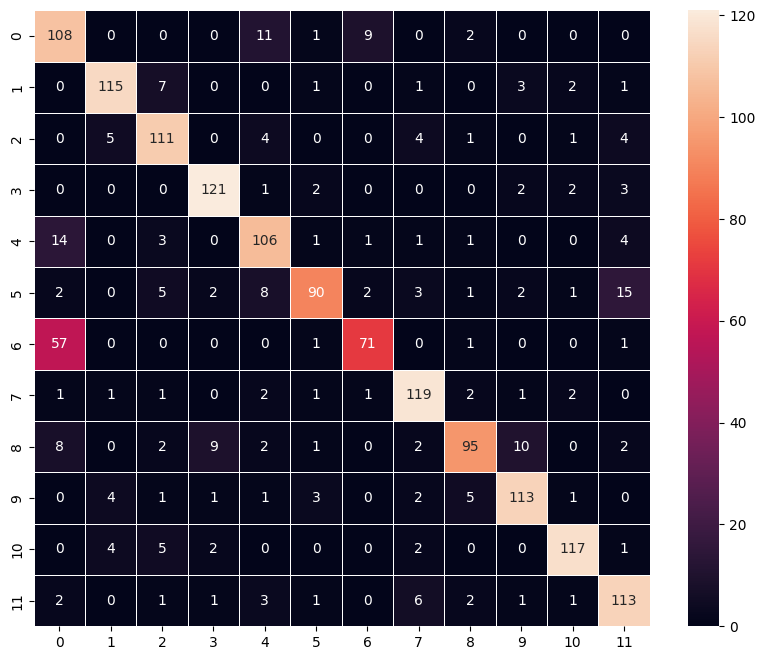

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

<b> Observations</b><br>
- The confusion matrix improved dramatically from the first time I ran this model. However it always had trouble predicting the 6th class. I could never get it to improve much more than this.
- If I had more time I would like to investigate this further and figure out how to improve this models performance on the 6th class.
- the 0,4,9 classes have some confusion as well.

## Model 2 - Transfer Learning using VGG16

In [ ]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a dense output layer
new_model.add(Dense(32, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(16, activation='relu'))
new_model.add(Dense(12, activation='softmax'))
opt=Adam()
# Compile model
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    mode='auto',
    min_lr=0.00001
)

# Generating the summary of the model
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 12)                204       
                                                                 
Total params: 14780988 (56.38 MB)
Trainable params: 6630

In [ ]:
# Epochs
epochs = 50
# Batch size
batch_size = 32

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_resampled), y=y_resampled)
class_weights_dict = dict(enumerate(class_weights))

history_VGG = new_model.fit(train_datagen.flow(X_train_normalized,y_train,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val),
                    class_weight=class_weights_dict,
                            callbacks=[reduce_lr],
                    verbose=1)

Epoch 1/50
156/156 [==============================] - 8s 39ms/step - loss: 2.3900 - accuracy: 0.1541 - val_loss: 2.2196 - val_accuracy: 0.2237 - lr: 0.0010
Epoch 2/50
156/156 [==============================] - 6s 39ms/step - loss: 2.1607 - accuracy: 0.2341 - val_loss: 2.0265 - val_accuracy: 0.2818 - lr: 0.0010
Epoch 3/50
156/156 [==============================] - 6s 39ms/step - loss: 2.0055 - accuracy: 0.2876 - val_loss: 1.8854 - val_accuracy: 0.3368 - lr: 0.0010
Epoch 4/50
156/156 [==============================] - 6s 39ms/step - loss: 1.9214 - accuracy: 0.3064 - val_loss: 1.8358 - val_accuracy: 0.3583 - lr: 0.0010
Epoch 5/50
156/156 [==============================] - 6s 39ms/step - loss: 1.8573 - accuracy: 0.3395 - val_loss: 1.7456 - val_accuracy: 0.3869 - lr: 0.0010
Epoch 6/50
156/156 [==============================] - 6s 39ms/step - loss: 1.7827 - accuracy: 0.3541 - val_loss: 1.6729 - val_accuracy: 0.4172 - lr: 0.0010
Epoch 7/50
156/156 [==============================] - 6s 38ms/st

Observations:
* A little bit of overfitting but the accuracy is not high enough.

### Model Evaluation

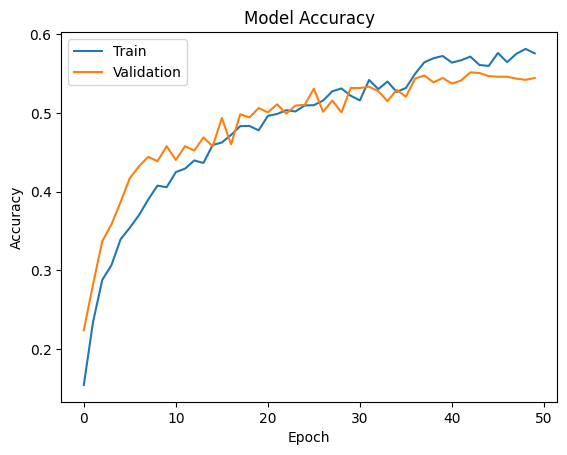

In [ ]:
plt.plot(history_VGG.history['accuracy'])
plt.plot(history_VGG.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### **Evaluating the model on test data**

In [ ]:
accuracy = new_model.evaluate(X_test_normalized, y_test, verbose=2)

50/50 - 1s - loss: 1.3024 - accuracy: 0.5548 - 1s/epoch - 24ms/step


### **Generating the predictions using test data**

In [ ]:
# Here we would get the output as probablities for each category
y_pred=new_model.predict(X_test_normalized)

50/50 [==============================] - 1s 14ms/step


In [ ]:
y_pred

array([[5.5498374e-05, 6.8532854e-01, 4.3526914e-02, ..., 4.6841655e-04,
        2.1149559e-02, 6.6886004e-03],
       [4.0940835e-05, 2.4806088e-01, 6.5417729e-02, ..., 5.2084867e-02,
        4.5073420e-01, 6.2726341e-02],
       [2.7622646e-04, 5.8198616e-02, 8.5789955e-01, ..., 7.1407300e-03,
        4.7548446e-03, 1.3602068e-02],
       ...,
       [5.9203288e-05, 5.5416375e-01, 1.9403887e-01, ..., 2.0089906e-02,
        1.6245393e-01, 2.7067347e-03],
       [6.2938292e-05, 4.3231513e-02, 1.8454503e-04, ..., 5.3107222e-05,
        1.3181578e-03, 1.3960714e-02],
       [1.7428189e-03, 9.0190537e-05, 9.0032449e-04, ..., 9.9015638e-02,
        5.1110453e-04, 6.5467563e-03]], dtype=float32)

### **Plotting the Confusion Matrix**

*   The Confusion matrix is also defined as an inbuilt function in the TensorFlow module, so we can use that for evaluating the classification model.
*   The Confusion matrix expects categorical data as input. However, y_test_encoded is an encoded value, whereas y_pred has probabilities. So,we must retrieve the categorical values from the encoded values.
*   We will use the `argmax()` function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes.





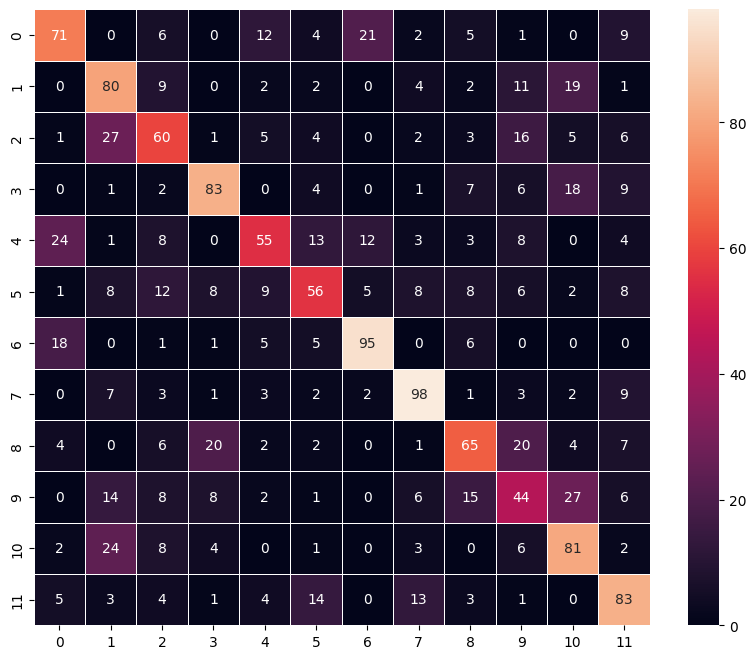

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

<b> Observations</b><br>
- The model performed much worse than my other model.
- The accuracy was not improving much the longer it trained.
- It was also beginning to overfit.
- One interesting note is that it struggled with the same classes as my other model.
- Accuracy 55.4% Loss 1.3

## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

The final model that I will use is the custom model that I built. It greatly outperformed the transfer model that I used. My model summary is below to review. I took a lot of trial and error to get a good fitting model. I experimented with learning rate schedulers, various callbacks, a lot of different combinations of neurons in each layer. But in the end a simpler architecture and heavy trainable paramiters at each layer was most successful. I ran into a lot of issues and bugs building this model which I had to troubleshoot and even started over in a clean enviornment a couple of times. It was hard work but I learned a lot!

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        9232      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 16)        0         
 g2D)                                                   

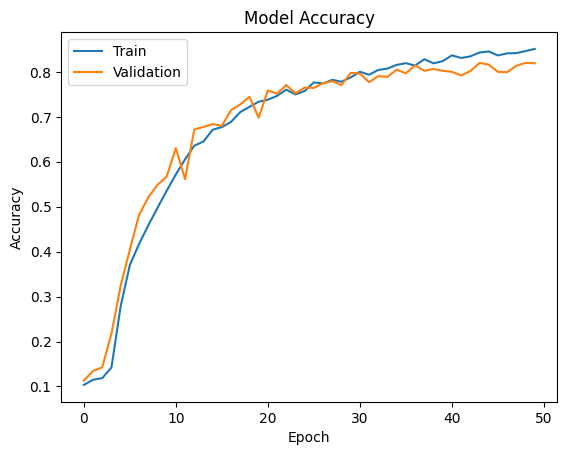

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
accuracy = model.evaluate(X_test_normalized, y_test, verbose=2)

50/50 - 0s - loss: 0.5682 - accuracy: 0.8146 - 308ms/epoch - 6ms/step


In [ ]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

50/50 [==============================] - 0s 5ms/step


### Visualizing the prediction

In [ ]:
y_pred

array([[8.9371013e-13, 9.9682164e-01, 7.7543053e-04, ..., 2.5675459e-05,
        2.3338799e-03, 1.4035513e-07],
       [1.9316984e-08, 9.8159731e-08, 1.1946631e-06, ..., 2.5952862e-05,
        3.2964027e-01, 1.9122248e-05],
       [5.0734980e-07, 8.7714382e-04, 9.5725012e-01, ..., 7.2084542e-05,
        4.0939805e-05, 5.1491792e-05],
       ...,
       [1.9335407e-11, 1.6509248e-04, 9.5782584e-01, ..., 2.8218066e-05,
        8.1964144e-03, 5.9126731e-04],
       [3.4462269e-06, 1.3447633e-03, 2.4323968e-02, ..., 6.1215676e-04,
        3.2554912e-05, 9.5225777e-03],
       [5.3462430e-09, 2.0439371e-05, 5.4932135e-04, ..., 3.5803553e-03,
        8.5936299e-06, 6.3410040e-04]], dtype=float32)

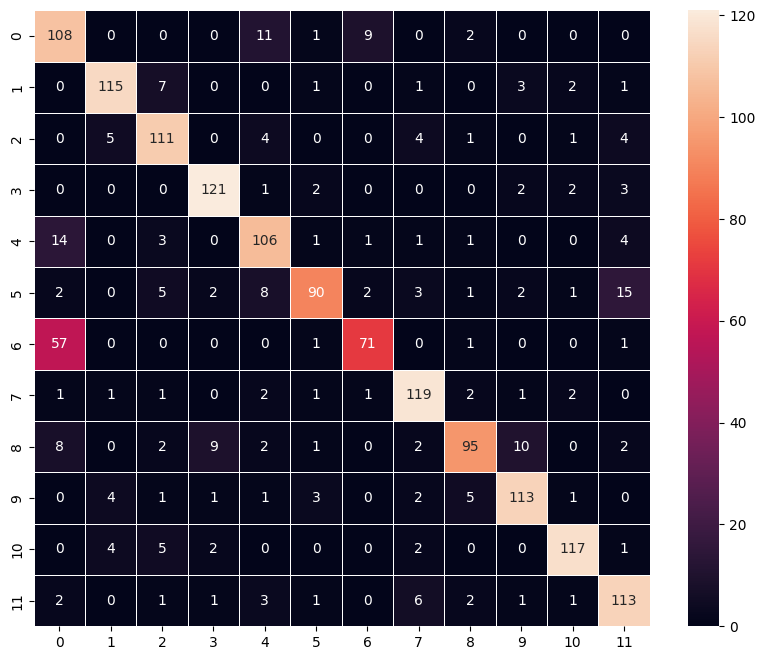

In [ ]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

## Actionable Insights and Business Recommendations

* I would suggest that a threshold of accuracy be defined.
* If the threshold is 80% then my model is capable of assisting the farmers in accuratly identifying these 12 species of plants.
* However if the threshold was 90% then I could remove the species of plants that my model was struggling to predict and build a new model that could accuratly predict the remainder of the specieas at greater than 90% accuracy.
* A larger dataset would be helpful to train future models.
* Even with the same data set, this field of deep learning is constantly improving and growing. So a model that could not get a desired result today could very well achieve that desired result next year.

_____

## Code to convert to HTML - kindly disregard

In [ ]:
# Mount Google drive to access the dataset (monkeys_dataset.zip)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from nbconvert import HTMLExporter
import nbformat

# Load the Colab notebook
notebook_path = '/content/drive/MyDrive/Colab Notebooks/Fields_CV_Project8_Full_Code_V2.ipynb'  # Replace with your notebook's path
notebook = nbformat.read(notebook_path, as_version=4)

# Create an HTMLExporter instance
html_exporter = HTMLExporter()

# Convert the notebook to HTML
(html, _) = html_exporter.from_notebook_node(notebook)

# Save the HTML to a file
output_file_path = '/content/drive/MyDrive/Google Drive/Documents/Personal/School/UT/UT Post Grad McCombs/AI/Project 8/Fields_CV_Project8_Full_Code_V2.html'  # Replace with your desired output path
with open(output_file_path, 'w', encoding='utf-8') as f:
    f.write(html)